In [1]:
# library import
import pandas as pd
import polars as pl
import numpy as np
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import random
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


%matplotlib inline

import os
import re
import glob
import shutil
import gc
from pathlib import Path
import xlsxwriter

# showing module
from IPython.display import display

# output display option adjustment
# precision of floating point in numpy
np.set_printoptions(suppress=True, precision=4)

# precision of floating point in pandas
pd.options.display.float_format = '{:.4f}'.format

# display all columns in dataframe
pd.set_option("display.max_columns",None)

# default font size in graph
plt.rcParams["font.size"] = 14

# graph display
sns.set(rc={'figure.figsize':(12,5)})

# random seed
random_seed = 49

In [2]:
# create the input_dir（input directory）
current_note_path = os.path.dirname(os.path.abspath('__file__'))
INPUT_DIR = os.path.join(current_note_path, "data")

# if INPUT_DIR has not been created yet, create it
if not os.path.isdir(INPUT_DIR):
    os.mkdir(INPUT_DIR)

# output_dir(output directory) creation
OUTPUT_DIR = os.path.join(current_note_path, 'outputs')

# if OUTPUT_DIR has not been created yet, create it
if not os.path.isdir(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [3]:
# # Once you run this code, comment it out
# # move csv files to `data` directory(=folder)
# unique_dir_names = []
# for f in Path(f'{current_note_path}').rglob('*.csv'):
#     unique_dir_names.append(f)

# for file in list(set(unique_dir_names)):
#     print(f'moved file: {file}')
#     shutil.move(f'{file}', f'{INPUT_DIR}')

In [4]:
# Polars function to let us read csv files without having to specify the directory
def read_csv(name, **kwrgs):
    path = os.path.join(INPUT_DIR, name + '.csv')
    print(f'Load: {path}')
    return pl.read_csv(path, **kwrgs)

In [5]:
df = read_csv('Prius_Prime')
df.head()

Load: /Users/satoshiido/Documents/programming/statistical-analysis/582/Applied_MS_Exam/data/Prius_Prime.csv


Date,overall_miles,overall_MPG,interval_miles,interval_MPG,interval_gallons,interval_days,interval_MPG_hand_calculated,overall_miles_lag,overall_miles_diff_lag,interval_gallons_lag,interval_gallons_diff_lag,interval_miles_lag,overall_miles_diff_lead,overall_miles_lead
str,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,i64
"""2017-12-28""",1207,51.1,602.3,66.6,9.46,null,null,null,null,null,null,null,528,1735
"""2018-01-14""",1735,53.4,528.1,59.5,9.57,17,55.21,1207,-528,9.46,0.11,602.3,618,2353
"""2018-02-02""",2353,58.3,618.3,78.7,8.62,19,71.75,1735,-618,9.57,-0.95,528.1,645,2998
"""2018-02-18""",2998,60.5,644.3,70.1,9.9,16,65.06,2353,-645,8.62,1.29,618.3,589,3587
"""2018-03-03""",3587,61.0,588.7,63.6,9.91,13,59.39,2998,-589,9.9,0.01,644.3,212,3799


# Preprocessing

In [6]:
df = df.with_columns(
        pl.col("Date").str.to_date("%Y-%m-%d").set_sorted()
        ).with_columns(
        pl.col("Date").dt.year().alias("Year"), 
        pl.col("Date").dt.month().alias("Month")
        )

# calculate the rolling average of the 2 months
## sort the data by date and set the sorted index to date
df = df.sort("Date").set_sorted("Date")

df = df.with_columns(
    day_of_week = pl.col("Date").dt.weekday().alias("weekday"),
    # rolling average of miles over 2 months
    rol_avg_int_miles_2 = pl.mean("interval_miles").rolling(index_column="Date", period="2mo"),
    # rolling average of gallons over 2 months
    rol_avg_int_gallons_2 = pl.mean("interval_gallons").rolling(index_column="Date", period="2mo"),
    # exponentially weighted mean (EWMA) with a span of 3
    gallons_ewm_3 = pl.col("interval_gallons").ewm_mean(span=3),
    # exponentially weighted mean (EWMA) with a span of 3
    miles_ewm_3 = pl.col("interval_miles").ewm_mean(span=3),
    # exponentially weighted standard deviation (EWMA) with a span of 3
    gallons_rol_std_3 = pl.col("interval_gallons").ewm_std(span=3),
    # exponentially weighted standard deviation (EWMA) with a span of 3
    miles_rol_std_3 = pl.col("interval_miles").ewm_std(span=3)
)
df.head()

Date,overall_miles,overall_MPG,interval_miles,interval_MPG,interval_gallons,interval_days,interval_MPG_hand_calculated,overall_miles_lag,overall_miles_diff_lag,interval_gallons_lag,interval_gallons_diff_lag,interval_miles_lag,overall_miles_diff_lead,overall_miles_lead,Year,Month,day_of_week,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
date,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,i64,i32,u32,u32,f64,f64,f64,f64,f64,f64
2017-12-28,1207,51.1,602.3,66.6,9.46,null,null,null,null,null,null,null,528,1735,2017,12,4,602.3,9.46,9.46,602.3,0.0,0.0
2018-01-14,1735,53.4,528.1,59.5,9.57,17,55.21,1207,-528,9.46,0.11,602.3,618,2353,2018,1,7,565.2,9.515,9.533333,552.833333,0.077782,52.467323
2018-02-02,2353,58.3,618.3,78.7,8.62,19,71.75,1735,-618,9.57,-0.95,528.1,645,2998,2018,2,5,582.9,9.216667,9.011429,590.242857,0.599601,52.482514
2018-02-18,2998,60.5,644.3,70.1,9.9,16,65.06,2353,-645,8.62,1.29,618.3,589,3587,2018,2,7,598.25,9.3875,9.485333,619.073333,0.685496,48.46992
2018-03-03,3587,61.0,588.7,63.6,9.91,13,59.39,2998,-589,9.9,0.01,644.3,212,3799,2018,3,6,594.85,9.5,9.704516,603.396774,0.537679,38.124369


In [7]:
df2 = df[1:]
# df2.write_excel(os.path.join(OUTPUT_DIR, "Prius_Prime.xlsx"))
df2.head()

Date,overall_miles,overall_MPG,interval_miles,interval_MPG,interval_gallons,interval_days,interval_MPG_hand_calculated,overall_miles_lag,overall_miles_diff_lag,interval_gallons_lag,interval_gallons_diff_lag,interval_miles_lag,overall_miles_diff_lead,overall_miles_lead,Year,Month,day_of_week,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
date,i64,f64,f64,f64,f64,i64,f64,i64,i64,f64,f64,f64,i64,i64,i32,u32,u32,f64,f64,f64,f64,f64,f64
2018-01-14,1735,53.4,528.1,59.5,9.57,17,55.21,1207,-528,9.46,0.11,602.3,618,2353,2018,1,7,565.2,9.515,9.533333,552.833333,0.077782,52.467323
2018-02-02,2353,58.3,618.3,78.7,8.62,19,71.75,1735,-618,9.57,-0.95,528.1,645,2998,2018,2,5,582.9,9.216667,9.011429,590.242857,0.599601,52.482514
2018-02-18,2998,60.5,644.3,70.1,9.9,16,65.06,2353,-645,8.62,1.29,618.3,589,3587,2018,2,7,598.25,9.3875,9.485333,619.073333,0.685496,48.46992
2018-03-03,3587,61.0,588.7,63.6,9.91,13,59.39,2998,-589,9.9,0.01,644.3,212,3799,2018,3,6,594.85,9.5,9.704516,603.396774,0.537679,38.124369
2018-03-04,3799,60.3,212.0,50.7,4.41,1,48.13,3587,-212,9.91,-5.51,588.7,688,4487,2018,3,7,518.28,8.482,7.015238,404.592063,3.28918,243.026609


In [8]:
# calculate the year rolling (2months) average temperature
df2_by_year = df2.group_by("Year").agg(
    pl.col("interval_miles").count().alias("count_interval_miles"),
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3")
)
df2_by_year

Year,count_interval_miles,avg_interval_miles,avg_interval_MPG,avg_interval_gallons,avg_interval_days,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
i32,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2024,7,424.985714,62.971429,7.025714,12.571429,534.69915,7.000269,7.18998,484.712423,1.815652,256.73353
2022,24,565.4,73.979167,8.15,15.625,595.237654,8.182867,8.192621,566.488743,0.971356,173.08633
2021,15,670.066667,81.473333,8.651333,42.6,720.723635,8.809975,8.714627,663.777243,0.579149,231.77086
2018,15,654.993333,86.06,7.936,24.533333,719.127,8.261433,8.069176,649.598515,1.35863,283.854812
2019,17,634.576471,80.011765,8.434706,21.411765,661.61098,8.310373,8.355935,638.205229,1.066716,176.241729
2023,19,584.194737,79.731579,7.591053,18.526316,639.977686,7.433639,7.498956,566.528346,1.416979,223.832018
2020,4,452.575,60.05,8.1625,20.75,496.8375,8.192917,8.246962,493.062797,0.93545,132.307308


In [9]:
# calculate the year rolling (2months) average temperature
df2_by_month = df2.group_by("Month").agg(
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3"),
)
df2_by_month

Month,avg_interval_miles,avg_interval_MPG,avg_interval_gallons,avg_interval_days,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
7,613.88,77.066667,8.358667,15.133333,672.129833,8.409013,8.2831,591.58737,1.231327,178.144649
12,620.825,87.35,7.6025,28.0,702.814583,7.657083,7.754351,631.385628,1.092948,251.505217
11,676.45,92.7,7.383333,34.666667,778.515278,7.978472,7.728042,675.611761,1.079975,304.482718
9,715.071429,84.342857,8.898571,23.428571,577.227381,8.088759,8.624053,650.048121,1.015496,195.983817
5,736.05,90.783333,8.62,41.5,786.759167,8.609417,8.461416,689.310988,0.935905,262.495175
8,477.223077,67.346154,7.410769,10.0,579.049878,7.60226,7.571683,521.327626,1.250822,170.527094
6,556.983333,75.883333,7.815,17.0,649.280278,8.363417,8.175149,604.154158,0.99781,193.192227
4,543.56,66.16,8.774,9.4,589.563333,8.4784,8.549166,562.158761,0.791475,126.460723
1,530.591667,70.766667,7.794167,34.083333,653.604028,7.782694,7.795733,565.819946,1.018309,252.024554


In [10]:
# calculate the year rolling (2months) average temperature by day of week
df2_by_day_of_week = df2.group_by("day_of_week").agg(
    pl.col("interval_miles").mean().alias("avg_interval_miles"),
    pl.col("interval_MPG").mean().alias("avg_interval_MPG"),
    pl.col("interval_gallons").mean().alias("avg_interval_gallons"),
    pl.col("interval_days").mean().alias("avg_interval_days"),
    pl.col("rol_avg_int_miles_2").mean().alias("rol_avg_int_miles_2"),
    pl.col("rol_avg_int_gallons_2").mean().alias("rol_avg_int_gallons_2"),
    pl.col("gallons_ewm_3").mean().alias("gallons_ewm_3"),
    pl.col("miles_ewm_3").mean().alias("miles_ewm_3"),
    pl.col("gallons_rol_std_3").mean().alias("gallons_rol_std_3"),
    pl.col("miles_rol_std_3").mean().alias("miles_rol_std_3"),
)
df2_by_day_of_week

day_of_week,avg_interval_miles,avg_interval_MPG,avg_interval_gallons,avg_interval_days,rol_avg_int_miles_2,rol_avg_int_gallons_2,gallons_ewm_3,miles_ewm_3,gallons_rol_std_3,miles_rol_std_3
u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
5,546.75,71.386364,8.105,12.954545,595.467141,7.93081,8.003079,561.827014,1.255131,188.566877
1,676.3,89.492308,7.823077,30.538462,712.733297,8.04274,7.969862,625.460988,1.115255,254.333041
6,576.752632,77.773684,7.815263,35.631579,599.345439,7.77812,7.812974,570.659291,1.198779,188.020582
4,640.2,77.153333,8.806,24.266667,677.579627,8.445511,8.548177,653.037363,0.935556,233.504888
7,500.735,67.18,7.822,11.25,601.864196,8.15491,8.101391,554.321221,1.114322,196.478557
3,753.483333,97.4,8.28,33.333333,796.540278,8.462778,8.228631,693.761124,0.902699,277.281552
2,700.15,91.283333,7.858333,20.166667,714.512778,8.228944,8.080664,649.477756,1.210572,223.452169


# Plotting

Plot the Targeted Response Variable `interval_mileage` and `Overall Mileage` to see the distribution of the data.

Text(0.5, 0, 'Interval Miles')

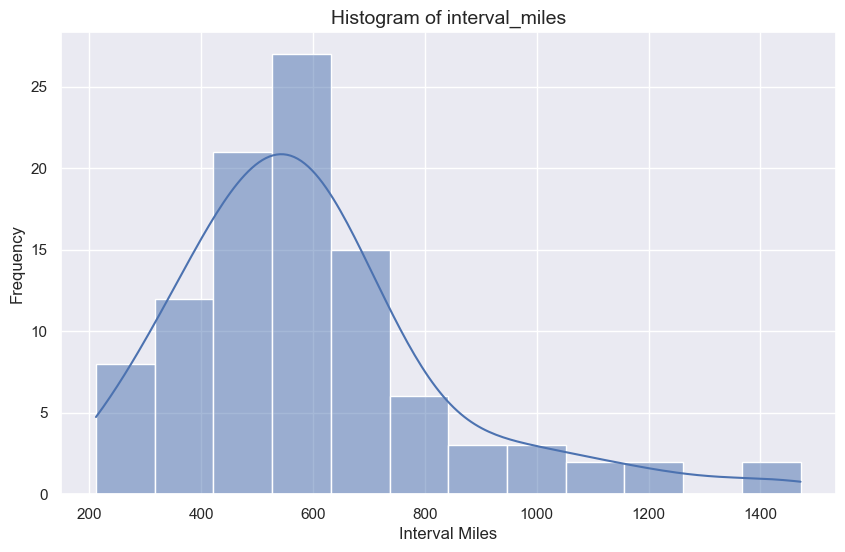

In [23]:
# Histogram of `interval_mileage`
plt.figure(figsize=(10, 6))
sns.histplot(data=df2, x="interval_miles", kde=True).set_title("Histogram of interval_miles", fontsize = 14)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Interval Miles', fontsize = 12)

Text(0.5, 1.0, 'Overall Mileage Changes from 2018-2024')

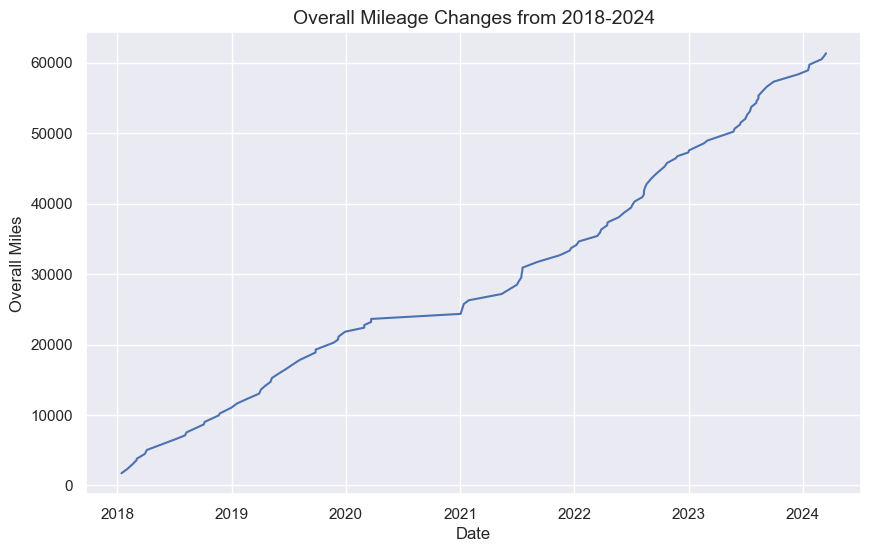

In [76]:
# Lineplot of `interval_MPG`
plt.figure(figsize=(10, 6))
# sort the data by year
df2 = df2.sort("Date")
plt.plot(df2["Date"], df2["overall_miles"], label="Overall Miles")
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Overall Miles', fontsize = 12)
plt.title('Overall Mileage Changes from 2018-2024', fontsize = 14)

Interval Mileage and Oil Consumption by year

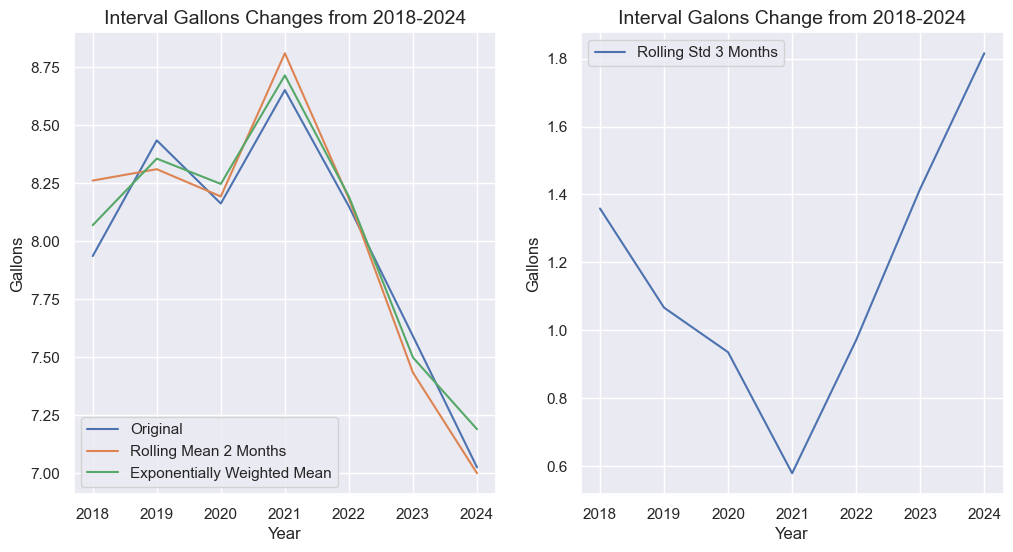

In [11]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_gallons"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Gallons Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Gallons", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Gallons", fontsize = 12)
ax2.legend()

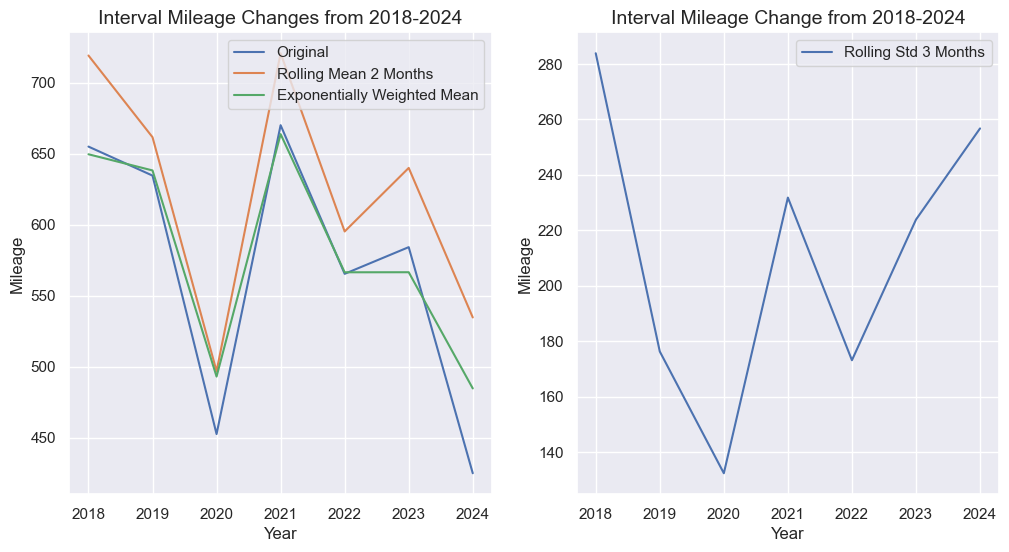

In [12]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_year = df2_by_year.sort("Year")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_year["Year"], df2_by_year["avg_interval_miles"], label="Original")
ax1.plot(df2_by_year["Year"], df2_by_year["rol_avg_int_miles_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_year["Year"], df2_by_year["miles_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Mileage Changes from 2018-2024", fontsize = 14)
ax1.set_xlabel("Year", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_year["Year"], df2_by_year["miles_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Mileage Change from 2018-2024", fontsize = 14)
ax2.set_xlabel("Year", fontsize = 12)
ax2.set_ylabel("Mileage", fontsize = 12)
ax2.legend()

Interval Mileage and Oil Consumption by month

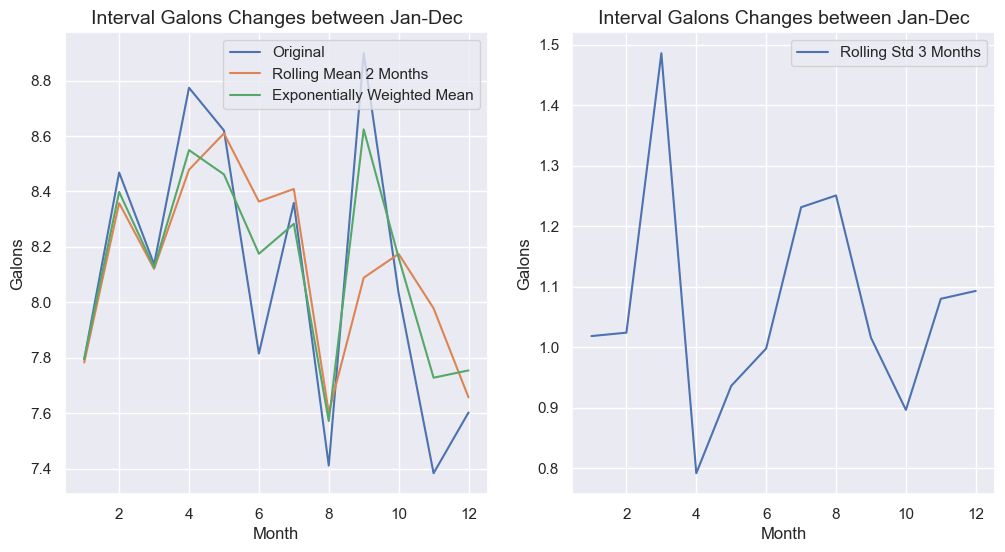

In [13]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_gallons"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Galons Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Galons", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Galons", fontsize = 12)
ax2.legend()

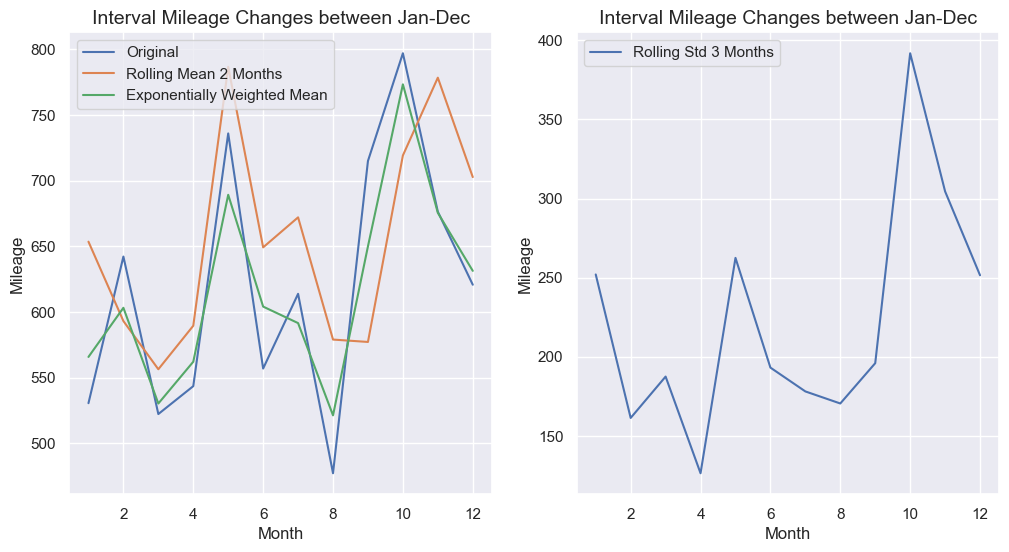

In [14]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_month = df2_by_month.sort("Month")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_month["Month"], df2_by_month["avg_interval_miles"], label="Original")
ax1.plot(df2_by_month["Month"], df2_by_month["rol_avg_int_miles_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_month["Month"], df2_by_month["miles_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Mileage Changes between Jan-Dec", fontsize = 14)
ax1.set_xlabel("Month", fontsize = 12)
ax1.set_ylabel("Mileage", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_month["Month"], df2_by_month["miles_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Mileage Changes between Jan-Dec", fontsize = 14)
ax2.set_xlabel("Month", fontsize = 12)
ax2.set_ylabel("Mileage", fontsize = 12)
ax2.legend()

Interval Mileage and Oil Consumption by day of week

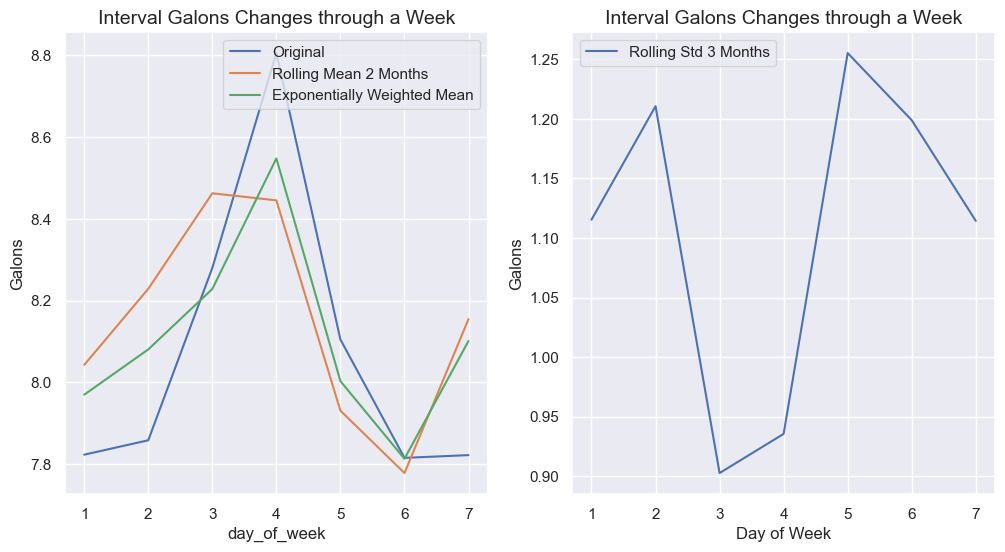

In [15]:
# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# sort the data by year
df2_by_day_of_week = df2_by_day_of_week.sort("day_of_week")

# temperature graph with rolling mean and exponentially weighted moving mean
# df_state_byyear = latest_df_state.group_by("Year").agg(pl.col("avg_temp").mean())
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["avg_interval_gallons"], label="Original")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["rol_avg_int_gallons_2"], label="Rolling Mean 2 Months")
ax1.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["gallons_ewm_3"], label="Exponentially Weighted Mean")
ax1.set_title("Interval Galons Changes through a Week", fontsize = 14)
ax1.set_xlabel("day_of_week", fontsize = 12)
ax1.set_ylabel("Galons", fontsize = 12)
ax1.legend()

# temperature graph with rolling std
ax2.plot(df2_by_day_of_week["day_of_week"], df2_by_day_of_week["gallons_rol_std_3"], label="Rolling Std 3 Months")
ax2.set_title("Interval Galons Changes through a Week", fontsize = 14)
ax2.set_xlabel("Day of Week", fontsize = 12)
ax2.set_ylabel("Galons", fontsize = 12)
ax2.legend()

# Paired t-test

In [29]:
# We now know that the computer generated interval mpg is always overestimated.
ttest_rel(df2["interval_MPG"], df2["interval_MPG_hand_calculated"], alternative="greater")

TtestResult(statistic=20.433862506531344, pvalue=8.874055471633647e-38, df=100)

# Data Split

In [26]:
# data split
train = df2.filter(pl.col("Year") < 2023).clone()
# val = df2[-60:-12].clone()
test = df2.filter(pl.col("Year") >= 2023).clone()

# Linear Regression Model
https://tinyurl.com/2ysx6lxg

In [29]:
train.select(['overall_miles_lag', "interval_miles", "interval_gallons_lag", "interval_miles_lag", "Year", "Month", "day_of_week"]).head()

overall_miles_lag,interval_gallons_lag,interval_miles_lag,Year,Month,day_of_week
i64,f64,f64,i32,u32,u32
1207,9.46,602.3,2018,1,7
1735,9.57,528.1,2018,2,5
2353,8.62,618.3,2018,2,7
2998,9.9,644.3,2018,3,6
3587,9.91,588.7,2018,3,7


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def run_linear_regression(train, test):
    lr = LinearRegression()
    random.seed(49)

    X_train = train.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
    y_train = train.select("interval_miles")
    X_test = test.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
    y_test = test.select("interval_miles")

    lr.fit(X_train, y_train)
    print('coefficient = ', lr.coef_[0])
    print('intercept = ', lr.intercept_)

    y_pred = lr.predict(X_test)
    plt.scatter(y_pred, y_pred - y_test, color = '#1f77b4')
    plt.hlines(y = 0, xmin = -10, xmax = 600, color = '#d62728')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()
    plt.show()

    def measure_rmse(y_true, y_pred):
        return sqrt(mean_squared_error(y_true,y_pred))

    y_train_pred = lr.predict(X_train)
    rmse_train = measure_rmse(y_train, y_train_pred)
    rmse_test = measure_rmse(y_pred, y_test)

    # RMSE 
    print(f'The RMSE of the train that we will try to diminish is {round(rmse_train,4)}')
    print(f'The RMSE of the test is {round(rmse_test,4)}')

    # R^2
    print('r^2 train data: ', r2_score(y_train, y_train_pred))
    print('r^2 test data: ', r2_score(y_test, y_pred))

coefficient =  [ -0.029    7.2195  -0.2046 211.6938  28.0843 -26.456 ]
intercept =  [-426337.8622]


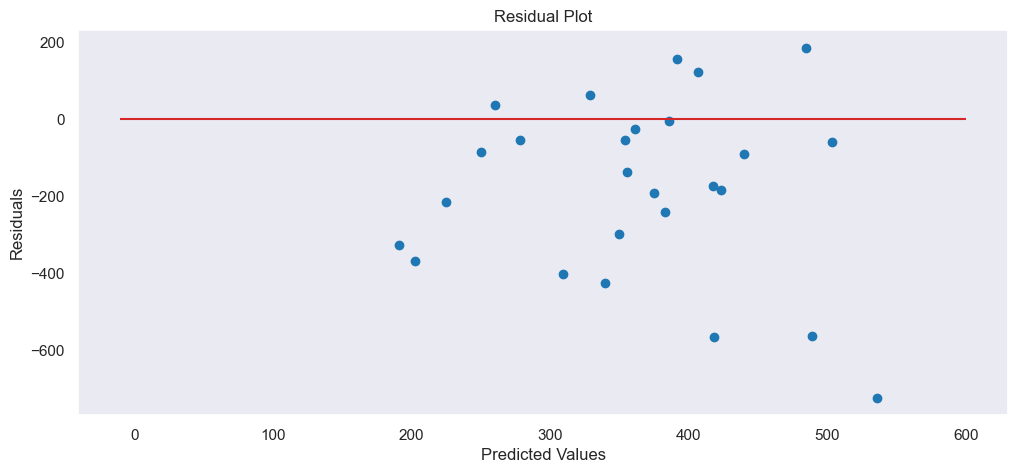

The RMSE of the train that we will try to diminish is 210.2878
The RMSE of the test is 287.9897
r^2 train data:  0.1785500690119347
r^2 test data:  -0.3192321203695845


In [49]:
run_linear_regression(train, test)

coefficient =  [ -0.029    7.2195  -0.2046 211.6938  28.0843 -26.456 ]
intercept =  [-426337.8622]


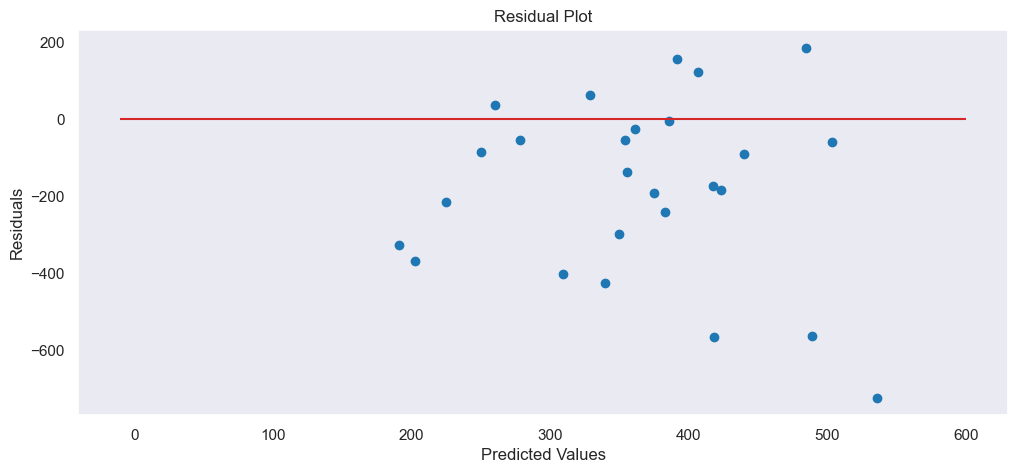

In [37]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
random.seed(49)

X_train = train.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
y_train = train.select("interval_miles")
X_test = test.select(pl.col("overall_miles_lag"), pl.col("interval_gallons_lag"), pl.col("interval_miles_lag"), pl.col("Year"), pl.col("Month"), pl.col("day_of_week")).to_numpy()
y_test = test.select("interval_miles")


lr.fit(X_train, y_train)
print('coefficient = ', lr.coef_[0])
print('intercept = ', lr.intercept_)

y_pred = lr.predict(X_test)
plt.scatter(y_pred, y_pred - y_test, color = '#1f77b4')
plt.hlines(y = 0, xmin = -10, xmax = 600, color = '#d62728')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()
plt.show()

In [41]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

y_train_pred = lr.predict(X_train)
rmse_train = measure_rmse(y_train, y_train_pred)
rmse_test = measure_rmse(y_pred, y_test)

# RMSE 
# possible over fitting
print(f'The RMSE of the train that we will try to diminish is {round(rmse_train,4)}')
print(f'The RMSE of the test is {round(rmse_test,4)}')

# R^2
from sklearn.metrics import r2_score
print('r^2 train data: ', r2_score(y_train, y_train_pred))
print('r^2 test data: ', r2_score(y_test, y_pred))

The RMSE of the train that we will try to diminish is 210.2878
The RMSE of the test is 287.9897
r^2 train data:  0.1785500690119347
r^2 test data:  -0.3192321203695845


Exclue the data in 2020 because there were pandemic and the data is not reliable.

In [46]:
df3 = df2.filter(pl.col("Year") != 2020)

run_linear_regression(train, test)

# ARIMA model

In [ ]:
# https://tinyurl.com/255aa9fz
# https://tinyurl.com/2ao94khk``

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

tscv = TimeSeriesSplit(n_splits = 4)
rmse = []
for train_index, test_index in tscv.split(df2):
    cv_train, cv_test = df2[:train_index], df2[train_index:test_index]
    
    arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    
    predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
    true_values = cv_test.values
    rmse.append(sqrt(mean_squared_error(true_values, predictions)))
    
print("RMSE: {}".format(np.mean(rmse)))
